# Think Bayes: Chapter 6

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from sympy import symbols
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd
import pdb
import scipy.stats

'Done'

'Done'

## Kernel density estimation for Price is Right showcases

In [2]:
pir11_df = mtb.DataSets.get_price_is_right('ThinkBayes2/code/showcases.2011.csv')
pir12_df = mtb.DataSets.get_price_is_right('ThinkBayes2/code/showcases.2012.csv')
pir_df = pd.concat([pir11_df, pir12_df])
display(pir_df.shape, pir_df.head())

(313, 6)

,bid1,bid2,diff1,diff2,showcase1,showcase2
0,42000,34000,8969,11429,50969,45429
1,14000,59900,7901,-25839,21901,34061
2,32000,45000,815,8186,32815,53186
3,27000,38000,17432,-6572,44432,31428
4,18750,23000,5523,-680,24273,22320


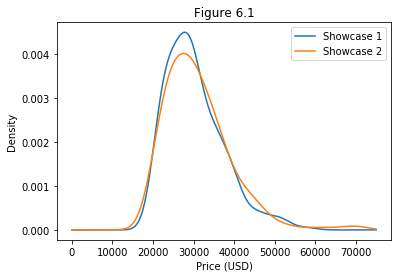

In [13]:
X = np.linspace(0, 75000, 1001)
sc1_pmf = mtb.PMF.from_kde(pir_df.showcase1, X)
sc2_pmf = mtb.PMF.from_kde(pir_df.showcase2, X)

plt.plot(sc1_pmf.hypos, sc1_pmf.probs, label='Showcase 1')
plt.plot(sc2_pmf.hypos, sc2_pmf.probs, label='Showcase 2')
plt.title('Figure 6.1')
plt.xlabel('Price (USD)')
plt.ylabel('Density')
plt.legend()
plt.show()

## Modeling the Contestants

The showcase price PMFs give us a reasonable prior on the price of each showcase.

Now we need to figure how to update these priors given new data, namely:

1. What data should we consider and how should we quantify it?
2. Can we compute a likelihood function; that is, for each hypothetical value of `price`, can we compute the conditional likelihood of the data?

Model each contestant as a price-guessing mechanism with known error characteristics:

1. Contestant sees the prizes.
2. Contestant guesses the price of each prize.
3. Contestant adds up the total prices, resulting in the `guess`.

This begs the question:

> If the actual price is `price`, what is the likelihood that the contestant's estimate would be `guess`?

$P(\text{guess | price})$

If we define `error = price - guess`, we should consider the question:

> What is the likelihood that the contestant's estimate is off by `error`?

$P(\text{price - guess}) = P(\text{error})$

To quantify $P(\text{error})$, we can look at the historical data again:

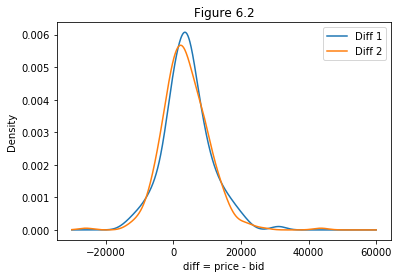

In [12]:
X = np.linspace(-30000, 60000, 1001)
diff1_pmf = mtb.PMF.from_kde(pir_df.showcase1 - pir_df.bid1, X)
diff2_pmf = mtb.PMF.from_kde(pir_df.showcase2 - pir_df.bid2, X)
plt.plot(X, diff1_pmf.probs, label='Diff 1')
plt.plot(X, diff2_pmf.probs, label='Diff 2')
plt.legend()
plt.xlabel('diff = price - bid')
plt.ylabel('Density')
plt.title('Figure 6.2')
plt.show()

Some observations about the distributions of `diff1` and `diff2`:
- The diffs are biased, in that it's more common to see an under-bid than an over-bid. This has to do with the rules of the game.

A couple notes on potentially ambiguous terminology:

1. Using `error = price - guess` and `diff = price - bid`: it seems the intention is that `error` and `guess` are used to describe the decision model of a player. `diff` and `bid` are used to describe the analagous observations from historical data and are also the column names in the given dataset.

2. The paragraph:

> Finally, we can use this distribution to estimate the reliability of the contestants' guesses. This step is a little tricky because we don't actually know the contestant's guesses; we only know what they bid.

I believe Downey is referring to the fact that a contestant's *guess* is different from her *bid*, in that the bid is affected by the rules and state of the game. For example, the contestant's bid might be an intentionally-decreased version of her guess which protects from going over the actual price.

Building off of the above empirical distributions of `price` and `diff`, we define `Player` and `Price` classes.

In [5]:
class Player:
    """Represents a player on The Price is Right."""
    
    prices_X = np.linspace(0, 75000, 101)
    
    def __init__(self, prices, diffs):
        
        # Need a random variable for prices, diffs, and error.
        # As a modeling assumption, the error gets centered at 
        # zero with standard deviation equal to that of diffs.
        self.prices_pmf = mtb.PMF.from_kde(prices, self.prices_X)
        self.diffs_cdf = mtb.PMF.from_observations(diffs).to_cdf()
        self.error_rv = scipy.stats.norm(0, np.std(diffs))
        
        self.prices_posterior = None    # Updated via set_guess function.
        
    def set_guess(self, guess):
        """Makes a posterior distribution based on the player's guess about the showcase.
        
        

        guess: what the player thinks the showcase is worth        
        """
        
        # Create a copy of the prior to be used as the posterior.
        self.prices_posterior = Price(self.prices_pmf.hypos, self.prices_pmf.probs)
        
        # Update the prior based on the guess.
        # The data getting passed is the guess and the pdf function 
        # needed to compute the density of the error resulting from the guess.
        self.prices_posterior.update((guess, self.error_rv.pdf))
        
class Price(mtb.PMF):
    """Represents hypotheses about the price of a showcase."""
        
    def likelihood(self, data, hypo):
        """P(data | hypo) = P(guess | price) = P(error).
        
        The pdf function used to compute P(error) gets passed as part of the data.
        """
        price = hypo
        guess, pdf_func = data
        error = price - guess
        return pdf_func(error)
    
'Done'

'Done'

Use the classes to re-create figure 6.3, which is based on the scenario:

1. Player 1 observes showcase 1.
2. Player bids $20000.
3. The posterior moves left of the prior

It might be hard to see what this update is doing. From the player's perspective, it's answering the question:

> I start with a prior belief about the prices of showcases based on historic data. Once I see the showcase, I make a guess about the price. Based on previous players' guesses, how should my guess update my belief about the price of the showcase? 

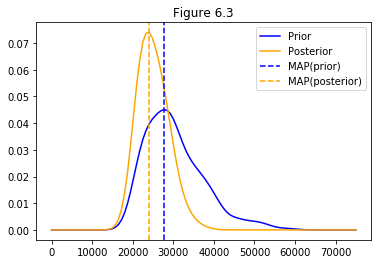

In [6]:
player = Player(pir_df.showcase1, pir_df.diff1)
player.set_guess(20000)

player.prices_pmf.plot(label='Prior', color='blue')
player.prices_posterior.plot(label='Posterior', color='orange')
plt.axvline(player.prices_pmf.MAP()[0], label='MAP(prior)', color='blue', linestyle='--')
plt.axvline(player.prices_posterior.MAP()[0], label='MAP(posterior)', color='orange', linestyle='--')
plt.legend()
plt.title('Figure 6.3')
plt.show()

## Optimal Bidding

We know how a player's guess updates her prior belief about the price of the showcase.

Now we need a way to compute an *optimal bid* based on our guess. In this case, we define the optimal bid to be the bid which maximizes expected return.

To compute this we make a `GainCalculator` class. Its most useful function is `expected_gains()`, which takes a list of bid values and returns the expected gain for each of the bids. From that we can compute the bid with maximum gain.

**To recap, our steps for computing an optimal bid are as follows.**

1. Instantiate two players.
2. Each player sees a showcase and makes a guess. This is arbitrarily picked by us. A more sophisticated model might include information about the showcase contents to make this guess.
3. We use each player's `set_guess()` function to update her prior over prices based on her guess.
4. Instantiate a `GainCalculator` instance for each player.
5. For player 1, compute the expected gain over a series of bids w.r.t. player 2. Vice versa for player 1.

The expected gain for a single bid can be expressed:

$ E[\text{Gain(bid)}] = \sum_i^N Pr(\text{price}_i) \times \text{Gain(price}_i\text{, bid)}$, where $N$ is the number of possible prices in the players' posterior over prices.

$ \text{diff = price - bid} $

$ \text{Gain(price, bid)} = 
\begin{cases}
0,  & \text{if diff} \lt 0 \\
2 \times \text{price} \times Pr(\text{win | price - bid}), & \text{if diff} \leq 250 \\
\text{price} \times Pr(\text{win | diff}) & \text{otherwise}
\end{cases}$

$Pr(\text{win | diff}) = Pr(\text{opponent overbids}) + Pr(\text{price - opponent bid > diff})$

$Pr(\text{opponent overbids})$ and $Pr(\text{price - opponent bid > diff})$ are computed using the opponent's CDF over diffs.

In [7]:
class GainCalculator:
    
    def __init__(self, player, opponent):
        self.player = player
        self.opponent = opponent
        
    def expected_gains(self, bids):
        """Compute the expected gains for a series of bids.
        
        First requires computing the player's posterior given a guess.
        
        This addresses the question:
        > Assuming the player has seen the showcase and guessed *guess*, 
          what is the expected gain for each of the bids?
    
        """
        eg = np.array([self._expected_gain(bid) for bid in bids])
        return eg, np.argmax(eg)
    
    def _expected_gain(self, bid):
        """Compute expected gain for a single bid."""
        total_gain = 0
        for price, prob in self.player.prices_posterior.items():
            total_gain += prob * self._gain(price, bid)
        return total_gain
    
    def _gain(self, price, bid):
        """Compute the gain for a specifc price and bid.
        
        gain = {
            0, if bid > price

            2 * price * P(win | price - bid), if price - bid <= 250
            
            price * P(win | price - bid)
        }
        """
        
        diff = price - bid
        
        # Lose if the bid exceeds the price.
        if diff < 0:
            return 0

        # Otherwise compute the probability of winning
        pwin = self._prob_win(diff)

        # If the bid is within 250 dollars, you win both showcases
        if diff <= 250:
            return 2 * price * pwin
        else:
            return price * pwin
        
    def _prob_win(self, diff):
        """Compute the probability of winning given the specific diff,
        where diff = price - bid.
        
        P(win | diff) = P(opponent loses | diff) = 
        P(opponent overbids) + P(opponent's diff exceeds the given diff)
        
        The last two probabilities above are computed based on the 
        historical information.
        """
        
        # Probability of opponent overbidding.
        p_overbid = self.opponent.diffs_cdf.lteq(-1)
        
        # Probability opponenent's diff is greater than player's diff.
        p_diff_greater = self.opponent.diffs_cdf.gt(diff)
        
        return p_overbid + p_diff_greater

'Done'

'Done'

Recreate figure 6.4, based on the steps:

1. Player 1's best guess is \$20000.
2. Player 2's best guess is \$40000
3. Compute and plot the expected gains for both players.

Note: this computation takes a rather long time. For $n$ prices and $m$ bids, the complexity to compute expected gains is $O(m\times n)$.

In [8]:
# Instantiate players with their respective showcase and diff histories.
p1 = Player(pir_df.showcase1, pir_df.diff1)
p2 = Player(pir_df.showcase2, pir_df.diff2)

# These are arbitrary guesses, as we have no information about the showcases' contents.
p1_guess = 20000
p2_guess = 40000

# Set both players' guesses before .
p1.set_guess(p1_guess)
p2.set_guess(p2_guess)

# Compute players' expected gains for the same set of bids.
bids = np.linspace(0, 75000, 101)
gc1 = GainCalculator(p1, p2)
gc2 = GainCalculator(p2, p1)
eg1, am1 = gc1.expected_gains(bids)
eg2, am2 = gc2.expected_gains(bids)

np.mean(eg1), np.mean(eg2)

(4448.308629141852, 7215.8568161893245)

In [9]:
# Compute both players' optimal bids.
print('Player 1 guess = $%d, optimal bid = $%d, expected gain = $%d' % (p1_guess, bids[am1], eg1[am1]))
print('Player 2 guess = $%d, optimal bid = $%d, expected gain = $%d' % (p2_guess, bids[am2], eg2[am2]))

Player 1 guess = $20000, optimal bid = $21000, expected gain = $16668
Player 2 guess = $40000, optimal bid = $31500, expected gain = $19365


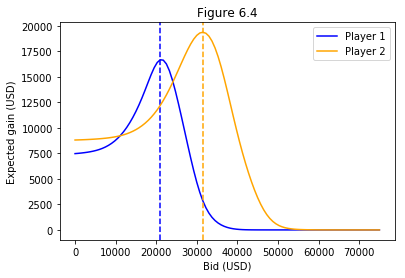

In [10]:
plt.plot(bids, eg1, label='Player 1', color='blue')
plt.axvline(bids[am1], color='blue', linestyle='--')
plt.plot(bids, eg2, label='Player 2', color='orange')
plt.axvline(bids[am2], color='orange', linestyle='--')
plt.xlabel('Bid (USD)')
plt.ylabel('Expected gain (USD)')
plt.title('Figure 6.4')
plt.legend()
plt.show()

In [11]:
'Done'

'Done'